In [1]:
% matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid
from numpy import linalg, random, ones, zeros, eye, dot
from numpy.linalg import norm, inv, cholesky
from scipy.linalg import solve_triangular
from scipy.sparse.linalg import spilu
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
from multiprocessing import Pool

initial_rho = 1.0
max_iter = 15
max_coord_iter = 35
initial_step_size = .1
timer_thresh = .5


def kernel(x1, x2):
    return math.exp(-1 * math.pow(norm(x1 - x2), 2
                                  ) / (2 * math.pow(sigma, 2)))


def kernel_vect(x_list, x2):
    return np.exp(-1 * np.power(norm(x_list - x2, axis=1), 2) / (2 * math.pow(sigma, 2)))


def loss_vect(t, rho):
    return np.power(np.maximum(np.zeros(t.shape), np.absolute(rho - t) - delta), 2)


def f(args):
    return f_expand(*args)


def f_expand(x_data, x_test, beta, rho):
    start = time.time()

    w = np.dot(beta, kernel_vect(x_data, x_test)) - rho

    end = time.time()
    if end - start > timer_thresh:
        print 'f:', end - start, 'sec'
    return w


def f_vect(slabSVM, x_test_matrix, beta, rho):
    start = time.time()

    w = np.empty(x_test_matrix.shape[0])
    for i in range(x_test_matrix.shape[0]):
        w[i] = np.dot(kernel_vect(slabSVM.x_data, x_test_matrix[i, :]), beta) - rho

    end = time.time()
    if end - start > timer_thresh:
        print 'f_vect:', end - start, 'sec'
    return w


def step(element, step_size, resid):
    return element - (step_size * resid)

def incomplete_cholesky_decomp4(K):
    start = time.time()

    assert K.shape[0] == K.shape[1]
    n = K.shape[0]

    K_prime = K.copy()
    G = np.zeros(K.shape)
    P = np.identity(K.shape[0])
    
    for j in range(n):
        G[j,j] = K[j,j]
    
    max_num = 0
    while np.sum(np.diagonal(G[i:n,i:n])) > .0001:
        max_num += 1
        
        j = np.argmax(np.diagonal(G[i:n,i:n]))+i
        
        P[i,i]=0
        P[j,j]=0
        P[i,j]=1
        P[j,i]=1

        # K_prime[0:n,i] <-> K_prime[0:n,j]
        temp = K_prime[0:n,i].copy()
        K_prime[0:n,i] = K_prime[0:n,j]
        K_prime[0:n,j] = temp

        # K_prime[i,0:n] <-> K_prime[j,0:n]
        temp = K_prime[i,0:n].copy()
        K_prime[i,0:n] = K_prime[j,0:n]
        K_prime[j,0:n] = temp
                
        # G[i,0:i+1] <-> G[j,0:i+1]
        temp = G[i,0:i+1].copy()
        G[i,0:i+1] = G[j,0:i+1]
        G[j,0:i+1] = temp

        G[i, i] = math.sqrt(K_prime[i, i])

        G[i + 1: n, i] = K_prime[ i + 1: n, i]

        a_sum= np.zeros(G[i + 1: n, 0].shape)
        for k in range(i):
            a_sum += G[i + 1: n, k] * G[i, k]
        G[i + 1: n, i] -= a_sum
        
        assert G[i, i] != 0
        G[i + 1: n, i] = G[i + 1: n, i] / G[i, i]
        
        for t in range(i+1,n):
            G[t,t] = K_prime[t,t]
            
            a_sum=0
            for k in range(i+1):
                a_sum += G[t, k] ** 2

            G[t, t] -= a_sum

    end = time.time()
    if end - start > timer_thresh:
        print 'incomplete_cholesky_decomp4:', end - start, 'sec'
    return G, P, max_num

class Slab_SVM:
    def get_H(self, opt_on):
        start = time.time()

        if opt_on == 'b':
            start1 = time.time()
            ret = gamma * 2 * self.K
            end1 = time.time()
            if end1 - start1 > timer_thresh:
                print 'get_H - part I:', end1 - start1, 'sec'

            start1 = time.time()
            ret += 2 / (v) * self.K_K
            end1 = time.time()
            if end1 - start1 > timer_thresh:
                print 'get_H - part II:', end1 - start1, 'sec'

        elif opt_on == 'rho':
            ret = 2 / (v * self.m)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_H:', end - start, 'sec'
        return ret

    def loss_der_der(self, t, rho):
        if abs(rho - t) < delta:
            return 0
        else:
            return 2

    def loss_der(self, grad, t, rho, opt_on):
        grad = 0
        if opt_on == 'b':
            if rho - t > delta:
                grad = -2.0 * (rho - t - delta)
            if -rho + t > delta:
                grad = 2.0 * (-rho + t - delta)
            return grad
        if opt_on == 'rho':
            if rho - t > delta:
                grad = 2.0 * (rho - t - delta)
            if -rho + t > delta:
                grad = -2.0 * (-rho + t - delta)
            return grad
        raise Exception(grad, g_loss_type, t, rho, delta)

    def loss_der_vect(self, t, rho, opt_on):
        grad = np.zeros(t.shape)
        if opt_on == 'b':
            grad[rho - t > delta] = -2.0 * (rho - t[rho - t > delta] - delta)
            grad[-rho + t > delta] = 2.0 * (-rho + t[-rho + t > delta] - delta)
            return grad
        if opt_on == 'rho':
            grad[rho - t > delta] = 2 * (rho - t[rho - t > delta] - delta)
            grad[-rho + t > delta] = -2 * (-rho + t[-rho + t > delta] - delta)
            return grad
        raise Exception(grad, g_loss_type, t, rho, delta)

    def z(self, x1, w, b):
        #         w = random.normal(0, 1.0/sigma, size=(D,len(x1)))
        #         b = random.uniform(0,2*np.pi,size=D)
        return math.sqrt(2.0 / D) * np.cos(np.dot(w, x1) + b)

    def obj_funct(self, beta, rho):
        start = time.time()

        obj = gamma * np.dot(beta, np.dot(self.K, beta)) + \
              1.0 / (v * self.m) * np.sum(loss_vect(np.dot(self.K, beta), rho)) - rho

        end = time.time()
        if end - start > timer_thresh:
            print 'obj_funct:', end - start, 'sec'
        return obj

    def backtrack_step_size(self, step_size, obj, resid, grad, beta, rho, opt_on):
        start = time.time()

        min_step_size = sys.float_info.epsilon

        if step_size == min_step_size:
            step_size = initial_step_size
        else:
            step_size = step_size * (2 ** 20)
            
        iters = 0
#         c = .000001
#         (c*step_size*np.dot(grad, resid)) + \
        while obj <= (self.obj_funct(step(beta, step_size, resid), rho) if opt_on == 'b' \
                              else self.obj_funct(beta, step(rho, step_size, resid))):
            iters += 1
            step_size = step_size * 0.7
            assert not math.isnan(step_size)
            if step_size < min_step_size:
                step_size = min_step_size
                end = time.time()
                #                 if end - start > timer_thresh:
                print 'backtrack_step_size:', end - start, 'sec iters', iters, \
                      'opt_on', opt_on, \
                      ' WARNING: step size not found'
                return step_size

        assert obj > (self.obj_funct(step(beta, step_size, resid), rho) if opt_on == 'b' \
                          else self.obj_funct(beta, step(rho, step_size, resid)))

        end = time.time()
        if end - start > timer_thresh:
            print 'backtrack_step_size:', end - start, 'sec, iters', iters, 'opt_on', opt_on
        return step_size

    def get_resid(self, beta, rho, grad, loss_vect_list, opt_on):
        start = time.time()
        #         self.H = self.get_H(beta,rho,loss_vect_list,opt_on)

        if opt_on == 'b':
            if is_approx:
                resid = np.dot(self.incomplete_cholesky_T_inv,
                               np.dot(self.incomplete_cholesky_inv, grad))
#                 resid = self.incomplete_cholesky.solve(grad)
            else:
                if Use_Cholesky:
                    resid = np.dot(self.L_T_inv, np.dot(self.L_inv, grad))
                else:
                    resid = np.dot(self.H_inv, grad)
        else:
            resid = grad  # /self.H

        end = time.time()
        if end - start > timer_thresh:
            print 'get_resid:', end - start, 'sec'
        return resid

    def obj_grad(self, opt_on):
        start = time.time()

        if opt_on == 'b':
            grad = gamma * 2.0 * np.dot(self.K, self.beta)
            for i in range(self.m):
                grad += 1.0 / (v * self.m) * (self.K[i] * self.loss_der(0,
                                                                        np.dot(self.K[i], 
                                                                               self.beta),
                                                                        self.rho,
                                                                        opt_on))

        elif opt_on == 'rho':
            grad = 1 / (v * self.m) * np.sum(self.loss_der_vect(np.dot(self.K, self.beta), 
                                                                self.rho,
                                                                opt_on)) - 1

        else:
            print '[obj_grad] Error'

        end = time.time()
        if end - start > timer_thresh:
            print 'obj_grad:', end - start, 'sec'
        return grad

    def grad_des_iterate(self, opt_on='b'):
        start = time.time()
        loss_vect_list = np.where(np.absolute(self.rho - np.dot(self.K, self.beta)) >= delta)[0]
        end = time.time()
        if end - start > timer_thresh:
            print 'find sv:', end - start, 'sec'

        obj = self.obj_funct(self.beta, self.rho)
        if obj < -self.rho:
            raise Exception(obj)
        # self.obj_array[self.iterations]=(obj)

        self.grad = self.obj_grad(opt_on)

        #         self.obj_grad_array[self.iterations]=norm(self.grad)

        if norm(self.grad) < (min_grad_rho if opt_on == 'rho' else min_grad_beta):
            print 'Stopping crit: norm(grad) small', norm(self.grad), 'opt_on', opt_on
            return True

        resid = self.get_resid(self.beta, self.rho, self.grad, loss_vect_list, opt_on)

        if opt_on == 'rho':
            self.step_size_rho = self.backtrack_step_size(self.step_size_rho, obj, resid,
                                                          self.grad, self.beta,
                                                          self.rho, opt_on)
            self.rho = max(0, step(self.rho, self.step_size_rho, resid))  # Update
        else:
            self.step_size_beta = self.backtrack_step_size(self.step_size_beta, obj, resid,
                                                           self.grad, self.beta,
                                                           self.rho, opt_on)
            self.beta = step(self.beta, self.step_size_beta, resid)  # Update

        end = time.time()
        if end - start > timer_thresh:
            print 'grad_des_iterate:', end - start, 'sec'

        return False

    def grad_des_coord(self, opt_on=''):
        start = time.time()
        for j in range(max_coord_iter):  # max_iter if i<max_iter-1 else 2*max_iter):
            self.iterations += 1
            converged = self.grad_des_iterate(opt_on=opt_on)
            if converged:
                break
        end = time.time()
        if end - start > timer_thresh:
            print 'grad_des_coord:', end - start, 'sec'

    def grad_des(self):
        start = time.time()

        self.obj_array = -1 * np.ones(max_iter)
        self.obj_grad_array = np.zeros((max_iter))
        self.obj_grad_check_array = np.zeros(max_iter)

        self.beta = zeros(self.m)
        self.rho = initial_rho

        self.grad_buffer = zeros(self.beta.shape)
        self.step_size_beta = initial_step_size
        self.step_size_rho = initial_step_size
        self.iterations = 0
        print 'obj', self.obj_funct(self.beta, self.rho)

        for i in range(max_iter):

            self.grad_des_coord(opt_on='b')

            self.grad_des_coord(opt_on='rho')

            if i == max_iter - 1:
                converged_b = self.grad_des_coord(opt_on='b')
                converged_b = self.grad_des_coord(opt_on='b')

            print 'obj', self.obj_funct(self.beta, self.rho)

            print 'grad b', norm(self.obj_grad('b')), 'grad rho', norm(self.obj_grad('rho'))

            print 'b', norm(self.beta), 'rho', self.rho

            print 'self.iterations', self.iterations

            if norm(self.obj_grad('b')) < min_grad_beta and \
                            norm(self.obj_grad('rho')) < min_grad_rho:
                print 'Stopping crit: norm(grad) small, opt_on b and rho'
                return True

            if i == max_iter - 1:
                print 'WARNING: Did not converge'

        end = time.time()
        #         if end - start > timer_thresh:
        print 'grad_des:', ((str(end - start) + ' sec') if end - start < 60 \
                                else (str((end - start) / 60.) + ' min'))

    def pop_K(self):
        start = time.time()

        self.K = np.zeros((self.m, self.m))

        if Fourier_Feature:
            z_cache = np.zeros((self.m,D))
            w = random.normal(0, 1.0/sigma, size=(self.m*D,len(self.x_data[0])))
            b = random.uniform(0,2*np.pi,size=self.m*D)
            for i in range(self.m):
                z_cache[i]=self.z(self.x_data[i],w[i:i+D,:],b[i:i+D])
            end = time.time()
            if end - start > timer_thresh:
                print 'z_cache:',end - start,'sec'

            for i in range(self.m):
                self.K[i,:] = np.dot(z_cache,z_cache[i])
#                 for j in range(self.m):
#                         self.z(self.x_data[i]),self.z(self.x_data[j]))
        else:
            for i in range(self.m):
                self.K[i, :] = kernel_vect(self.x_data, self.x_data[i])


        if Fourier_Feature:
                    K_test=np.zeros((self.m,self.m))
                    for i in range(self.m):
                        K_test[i,:] = kernel_vect(self.x_data,self.x_data[i])

                    print 'Fourier norm diff', norm(K_test-self.K)

        self.K_K = np.dot(self.K, self.K)

        self.H = self.get_H('b')

        if is_approx:
            incomplete_cholesky, P, k = incomplete_cholesky_decomp4(self.H.copy())

#             self.K_ilu = spilu(self.K.copy(),drop_tol=drop_tol)
#             self.K = np.dot(self.K_ilu.L.A,self.K_ilu.U.A)
#             self.K_K = np.dot(np.dot(self.K_ilu.L.A, self.K_ilu.U.A), np.dot(self.K_ilu.L.A,self.K_ilu.U.A))
#             self.H = self.get_H('b')
#             self.incomplete_cholesky = spilu(self.H.copy())#,drop_tol=drop_tol)
            
        else:
            if Use_Cholesky:
                self.L = cholesky(self.H)                
                self.L_inv = solve_triangular(self.L, np.identity(self.L.shape[0]))
                self.L_T_inv = solve_triangular(self.L.T, np.identity(self.L.shape[0]))
            else:
                self.H_inv = inv(self.H)

        end = time.time()
        if end - start > timer_thresh:
            print 'pop_K:', end - start, 'sec'

    def get_K_inv(K):
        start = time.time()

        K_inv = inv(K)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_K_inv:', end - start, 'sec'
        return K_inv

    def get_K_cond(K):
        start = time.time()

        K_cond = linalg.cond(K)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_K_cond:', end - start, 'sec'
        return K_cond

    def pre_comp_K():
        start = time.time()

        K = get_K()

        end = time.time()
        if end - start > timer_thresh:
            print 'pre_comp_K:', end - start, 'sec'
        return K  # , K_inv

    def __init__(self, x_data):
        start = time.time()
        self.x_data = x_data
        self.m = len(self.x_data)
        self.pop_K()
        if np.min(linalg.eigvals(self.K)) < 0:
            raise Exception(linalg.eigvals(self.K))
        if np.min(linalg.eigvalsh(self.K)) < 0:
            raise Exception(linalg.eigvalsh(self.K))
        self.grad_des()
        end = time.time()
        if end - start > timer_thresh:
            print '__init__:', ((str(end - start) + ' sec') if end - start < 60 \
                                    else (str((end - start) / 60.) + ' min'))


def get_data_points(data_ratio):
    start = time.time()

    x = []
    f = open('bunny.obj.txt')
    for line in f:
        line = line.strip()
        if line != '' and line[0] != '#':
            line_split = line.split()
            if len(line_split) == 4 and line_split[0] == 'v':
                x.append(line_split[1:])
    x = np.array(x)
    x = x.astype(np.float)
    x = sorted(x, key=lambda a_entry: a_entry[0])
    x = np.array(x)
    x = x[data_ratio * x.shape[0] / 10:, :]
    print 'points:', len(x)

    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:', end - start, 'sec'
    return x


grid_steps = 150


def proc_data(beta, rho, data):
    start = time.time()

    print 'delta', delta
    print 'rho', rho
    print 'np.abs(data - delta) < .1 -> ', (np.where(np.abs(data - delta) < .1)[0].shape)
    print 'np.abs(data - delta) < .01 -> ', (np.where(np.abs(data - delta) < .01)[0].shape)
    print 'np.abs(data - delta) < .001 -> ', (np.where(np.abs(data - delta) < .001)[0].shape)
    print 'np.abs(data - delta) < .0001 -> ', (np.where(np.abs(data - delta) < .0001)[0].shape)
    print 'data < delta -> ', (np.where(data < delta)[0].shape)
    print 'data > delta -> ', (np.where(data > delta)[0].shape)
    print 'data < 0 -> ', (np.where(data < 0)[0].shape)
    print 'data == 0 -> ', (np.where(data == 0)[0].shape)
    print 'data > 0 -> ', (np.where(data > 0)[0].shape)
    print 'min -> ', (np.amin(data))
    print 'max -> ', (np.amax(data))

    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:', ((str(end - start) + ' sec') if end - start < 60 \
                                    else (str((end - start) / 60.) + ' min'))


def pop_data_grid(slabSVM, beta, rho, x0_max, x1_max, x2_max, x0_min, x1_min, x2_min):
    start = time.time()
    data = np.zeros((grid_steps, grid_steps, grid_steps))

    x0_range = np.linspace(x0_min, x0_max, grid_steps)
    x1_range = np.linspace(x1_min, x1_max, grid_steps)
    x2_range = np.linspace(x2_min, x2_max, grid_steps)

    end = time.time()
    if end - start > timer_thresh:
        print 'alloc mem:', end - start

    pool = Pool(processes=4)

    args = []
    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                args.append((slabSVM.x_data,
                             np.asarray([x0_range[i],
                                         x1_range[j],
                                         x2_range[k]]),
                             slabSVM.beta,
                             slabSVM.rho,))

    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid args:', end - start, 'sec'

    eval_map = pool.map(f, args)

    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid pool map:', ((str(end - start) + ' sec') \
                                              if end - start < 60 \
                                              else (str((end - start) / 60.) + ' min'))

    counter = 0
    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                data[i, j, k] = eval_map[counter]
                counter += 1

    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid:', ((str(end - start) + ' sec') \
                                     if end - start < 60 \
                                     else (str((end - start) / 60.) + ' min'))
    return data


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


points: 2503


/Users/mich/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


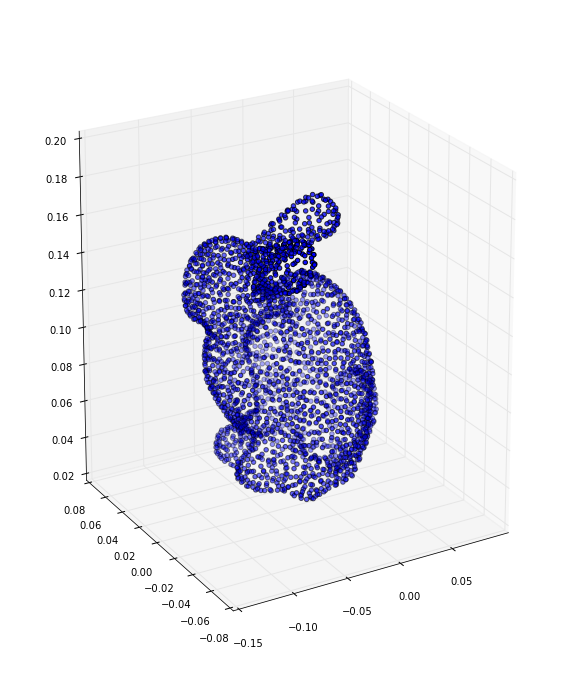

scatter: 0.763522148132 sec
-----------------------------------
v 0.0001
sigma 0.0084
gamma 1.0
pop_K: 2.71329212189 sec
obj 9999.0
backtrack_step_size: 0.639360189438 sec, iters 66 opt_on b
grad_des_iterate: 0.741599082947 sec
backtrack_step_size: 0.764537096024 sec iters 107 opt_on b  WARNING: step size not found
grad_des_iterate: 0.866797924042 sec
backtrack_step_size: 0.733687162399 sec iters 95 opt_on b  WARNING: step size not found
grad_des_iterate: 0.798264026642 sec
backtrack_step_size: 0.606275081635 sec iters 95 opt_on b  WARNING: step size not found
grad_des_iterate: 0.664541006088 sec
backtrack_step_size: 0.654440879822 sec iters 95 opt_on b  WARNING: step size not found
grad_des_iterate: 0.712435007095 sec
backtrack_step_size: 0.87028503418 sec iters 95 opt_on b  WARNING: step size not found
grad_des_iterate: 0.94185590744 sec
backtrack_step_size: 1.08204197884 sec iters 95 opt_on b  WARNING: step size not found
grad_des_iterate: 1.27392101288 sec
backtrack_step_size: 0.88

In [ ]:
g_loss_type = 'square-hinge'
g_method = 'Newton'
g_Desc = {}
g_counter=0

approx_avg = []
true_avg = []
approx_iterations = []
true_iterations = []

D = 1000
v = .0001
sigma = .0084
gamma = 1.
delta = 0.0
is_approx = False
Use_Cholesky = True
Fourier_Feature = False
data_ratio = 0
min_grad_beta = 0.00001
min_grad_rho =  0.00001

g_x = get_data_points(data_ratio)

x0_max = np.amax(g_x[:,0])
x0_min = np.amin(g_x[:,0])
x1_max = np.amax(g_x[:,1])
x1_min = np.amin(g_x[:,1])
x2_max = np.amax(g_x[:,2])
x2_min = np.amin(g_x[:,2])

start = time.time()
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_x[:,0],g_x[:,2],g_x[:,1])
ax.view_init(elev=20., azim=240)
plt.show()
end = time.time()
if end - start > timer_thresh:
    print 'scatter:',end - start,'sec'


# for drop_tol in [10**-6,10**-4,10**-2,1,2,0]:
g_counter += 1
print '-----------------------------------'
# print 'drop_tol',drop_tol
print 'v',v
print 'sigma',sigma
print 'gamma',gamma
g_Desc[g_counter] = Slab_SVM(g_x)
g_Desc[g_counter].end_obj = g_Desc[g_counter].obj_funct(g_Desc[g_counter].beta,g_Desc[g_counter].rho)
print 'obj',g_Desc[g_counter].obj_funct(g_Desc[g_counter].beta,g_Desc[g_counter].rho)
print 'norm(grad)',norm(g_Desc[g_counter].obj_grad('b'))
print 'Desc iterations',g_Desc[g_counter].iterations
print 'Desc rho',g_Desc[g_counter].rho
print '-----------------------------------'
print 

In [ ]:
g_m = len(g_x)

start = time.time()
losses = []
for i in range(g_m):
    losses.append(f((g_Desc[g_counter].x_data, g_x[i], g_Desc[g_counter].beta, 
                     g_Desc[g_counter].rho)))
losses = np.asarray(losses)
end = time.time()
if end - start > timer_thresh:
    print 'losses = []:',end - start,'sec'

if is_approx:
    approx_avg.append(np.average( losses ))
    approx_iterations.append(g_Desc[g_counter].iterations)
else:
    true_avg.append(np.average( losses ))
    true_iterations.append(g_Desc[g_counter].iterations)

print 'losses min -> ',(np.amin( losses ))
print 'losses argmin -> ',(np.argmin( losses ))
print 'losses x[min] -> ',g_x[(np.argmin( losses ))]
print 'losses max -> ',(np.amax( losses ))
print 'losses argmax -> ',(np.argmax( losses ))
print 'losses x[max] -> ',g_x[(np.argmax( losses ))]
print 'v',v
print 'sigma',sigma

data = pop_data_grid(g_Desc[g_counter], g_Desc[g_counter].beta,g_Desc[g_counter].rho,
                     x0_max,x1_max,x2_max,x0_min,x1_min,x2_min)

proc_data(g_Desc[g_counter].beta,g_Desc[g_counter].rho,data)


losses = []: 0.695336818695 sec
losses min ->  -0.000515541815407
losses argmin ->  2495
losses x[min] ->  [ 0.05979814  0.05684018  0.01334273]
losses max ->  0.00041642384831
losses argmax ->  2502
losses x[max] ->  [ 0.0607788   0.06164656  0.01046399]
v 0.0001
sigma 0.0084


In [ ]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

for elev in [180,120,60,90]:
    for azim in [30,90,180,240]:
        # Display resulting triangular mesh using Matplotlib. This can also be done
        # with mayavi (see skimage.measure.marching_cubes docstring).
        fig = plt.figure(figsize=(10, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        ax.add_collection3d(mesh)
        ax.view_init(elev=elev, azim=azim)

        ax.set_xlim(0,grid_steps)  
        ax.set_ylim(0,grid_steps)  
        ax.set_zlim(0,grid_steps)  

        plt.show()
#         break
#     break


In [ ]:
surface_data = []
for i in range(grid_steps):
    for j in range(grid_steps):
        for k in range(grid_steps):
            if abs(data[i,j,k]) < .002:
                surface_data.append([i,j,k])
surface_data = np.asarray(surface_data)
print surface_data.shape

fig1 = plt.figure(figsize=(10, 12))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax1.view_init(elev=180., azim=240)
plt.show()

fig2 = plt.figure(figsize=(10, 12))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax2.view_init(elev=90., azim=240)
plt.show()

fig3 = plt.figure(figsize=(10, 12))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax3.view_init(elev=100., azim=240)
plt.show()


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

print  approx_avg 
print  true_avg 
# approx_iterations = []
# true_iterations = []

ax.scatter(range(1,len(approx_avg)+1),
           approx_avg,marker='^',
           label='Approximate Low Rank Kernel')
ax.scatter(range(1,len(true_avg)+1),
           true_avg,marker='*',
           label='Exact Kernel')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Average Error vs Data Size')
plt.ylabel('Average Error')
plt.xlabel('Data Size')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

print  approx_iterations 
print  true_iterations 

ax.scatter(range(1,len(approx_iterations)+1),
           approx_iterations,marker='^',
           label='Approximate Low Rank Kernel')
ax.scatter(range(1,len(true_iterations)+1),
           true_iterations,marker='*',
           label='Exact Kernel')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Descent Iterations vs Data Size')
plt.ylabel('Descent Iterations')
plt.xlabel('Data Size')


In [ ]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_x[:,0],g_x[:,2],g_x[:,1])
ax.view_init(elev=20., azim=240)
plt.show()


In [ ]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-1, 30)  
ax.set_ylim(-1, 30)  
ax.set_zlim(-1, 30)  

ax.view_init(elev=20., azim=240)

plt.show()
